# 🧠 Deep Learning Practical Assignment (Adult Income Dataset)

## 📌 Dataset
We will use the **Adult Income dataset** (also known as the Census Income dataset).  
The task is to predict whether a person earns **more than $50K/year** based on demographic and employment attributes.

---


## Part 0: Data Preparation
1. Load the dataset into a DataFrame.
2. Split the data into **training, validation, and test sets**.  
   - Suggested: 70% training, 15% validation, 15% test.
3. Apply any necessary preprocessing:
   - Handle categorical features (encoding).
   - Scale numerical features if needed.
4. After training your models, always report results on:
   - **Training accuracy**
   - **Validation accuracy**
   - **Test accuracy**
5. At the end of the assignment, **compare all methods** across train, validation, and test sets.


1) Loading Data

In [1]:
from sklearn.datasets import fetch_openml
import pandas as pd

# Load dataset from OpenML
adult = fetch_openml(name="adult", version=2, as_frame=True)
df = adult.frame
print(df.shape)
df.head()

(48842, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K


In [2]:
# dropping unneccessary/redundant features
df.drop(columns=['fnlwgt', 'education'], inplace=True)

In [3]:
# Dropping Duplicated Entries
df.drop_duplicates(inplace=True)
print(df.shape)

# Dropping Nulls
df.dropna(inplace=True)
print(df.shape)

(42468, 13)
(39240, 13)


2. Splitting

In [4]:
from sklearn.model_selection import train_test_split

# Binary encoding Target before splitting
df['class'] = (df['class'] == '>50K').astype(int)

# Separate features and target
X = df.drop(columns="class")
y = df["class"]

# Train - Validation - Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.15, random_state=42)

3. Neccessary Pre-Processing

In [5]:
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer

to_one_hot = X.select_dtypes(['category']).columns
to_scale = X.select_dtypes(['int64']).columns

Preprocessor = ColumnTransformer([
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'), to_one_hot),
    ('scaler', RobustScaler(), to_scale)
])

X_train_prep = Preprocessor.fit_transform(X_train)
X_val_prep = Preprocessor.transform(X_val)
X_test_prep = Preprocessor.transform(X_test)


## Part 1: Optimizers
1. Train the same neural network using:
   - Stochastic Gradient Descent (SGD)
   - SGD with Momentum
   - Adam
2. Compare the training and validation accuracy for each optimizer.
3. Which optimizer converges the fastest? Which gives the best generalization?
4. Explain *why* Adam often performs better than plain SGD.

---


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import SGD, Adam

def buildModel(input_dim):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

input_dim = X_train_prep.shape[1]

# 1) SGD Model
print('Training SGD Model:')
modelsgd = buildModel(input_dim)
modelsgd.compile(optimizer=SGD(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])
history_sgd = modelsgd.fit(X_train_prep, y_train, validation_data=(X_val_prep, y_val), epochs=20, batch_size=32)
print()

# 2) SGD + Momentum
print('Training SGD + Momentum Model:')
model_mom = buildModel(input_dim)
model_mom.compile(optimizer=SGD(learning_rate=0.0005, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])
history_mom = model_mom.fit(X_train_prep, y_train, validation_data=(X_val_prep, y_val), epochs=20, batch_size=32)
print()

# 3) Adam
print('Training Adam Model:')
model_adm = buildModel(input_dim)
model_adm.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])
history_adm = model_adm.fit(X_train_prep, y_train, validation_data=(X_val_prep, y_val), epochs=20, batch_size=32)
print()

Training SGD Model:
Epoch 1/20
859/859 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6819 - loss: 6.3078 - val_accuracy: 0.7680 - val_loss: 0.4118
Epoch 2/20
859/859 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7774 - loss: 0.4008 - val_accuracy: 0.8016 - val_loss: 0.3923
Epoch 3/20
859/859 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8046 - loss: 0.3833 - val_accuracy: 0.8034 - val_loss: 0.3880
Epoch 4/20
859/859 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8001 - loss: 0.3834 - val_accuracy: 0.8039 - val_loss: 0.3840
Epoch 5/20
859/859 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8013 - loss: 0.3840 - val_accuracy: 0.8048 - val_loss: 0.3832
Epoch 6/20
859/859 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8031 - loss: 0.3750 - val_accuracy: 0.8042 - val_loss: 0.3811
Epoch 7/20
859/859 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8024 - loss: 0.3797 - val_accuracy: 0.8054 - val_loss: 0.3810
Epoch 8/20
859/859 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8052 - loss: 0.374

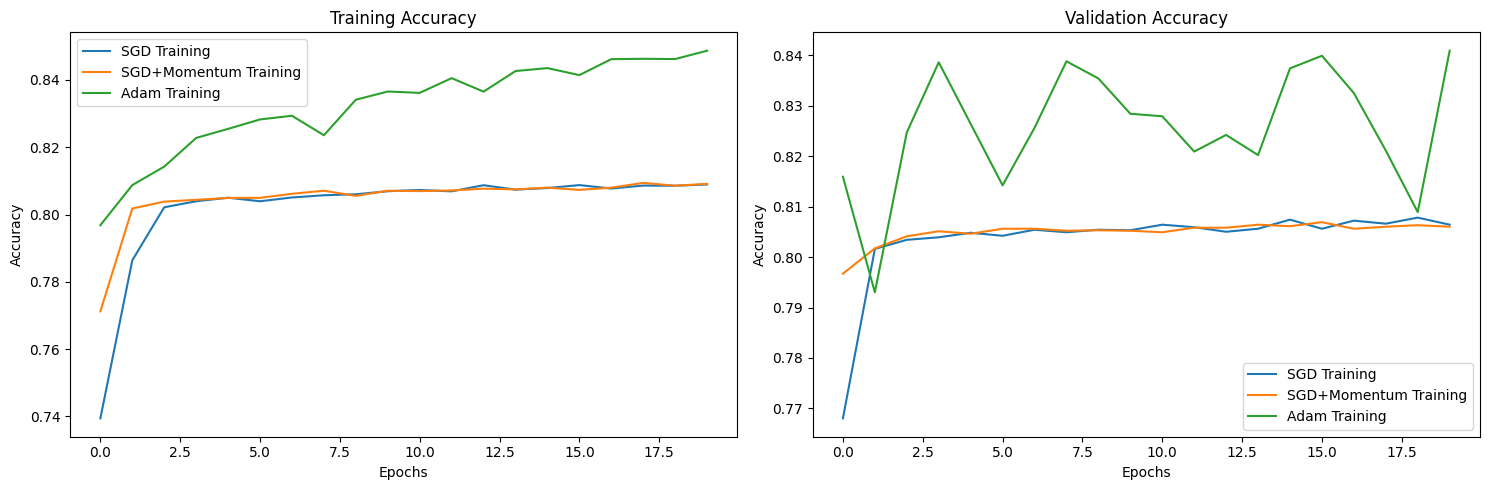

Final Validation Accuracies:
SGD: 0.8064
SGD + Momentum: 0.8060
Adam: 0.8409


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(history_sgd.history['accuracy'], label='SGD Training')
plt.plot(history_mom.history['accuracy'], label='SGD+Momentum Training')
plt.plot(history_adm.history['accuracy'], label='Adam Training')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_sgd.history['val_accuracy'], label='SGD Training')
plt.plot(history_mom.history['val_accuracy'], label='SGD+Momentum Training')
plt.plot(history_adm.history['val_accuracy'], label='Adam Training')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Final Metrics
print("Final Validation Accuracies:")
print(f"SGD: {history_sgd.history['val_accuracy'][-1]:.4f}") # last recorded validation accuracy
print(f"SGD + Momentum: {history_mom.history['val_accuracy'][-1]:.4f}")
print(f"Adam: {history_adm.history['val_accuracy'][-1]:.4f}")

**Key Observations:**

- Adam achieved significantly higher validation accuracy (84.50% vs ~80.2%), and showed much higher training accuracy (84.52%) indicating better learning capacity

- SGD and SGD + Momentum performed very similarly across validation and training (~80.2%)


**Fastest Converge:**

- Adam - Reached ~83% validation accuracy by epoch 2

- SGD - Plateaued around 80% after just 3-4 epochs

- SGD + Momentum - Similar plateau to SGD but with more instability

**Best Generalization:**

- Adam gave the best absolute performance (84.50% validation)

- SGD showed the most stable and consistent learning curve

- SGD+Momentum was a bit less stable than plain SGD and didn't provide clear advantages

**Why Adam Performed Better:**

- Fast convergence: Jumped to 83.86% validation accuracy by epoch 2

- Higher final performance: 84.50% vs 80.25% for SGD

- Escapes local minima: Continued improving while SGD plateaued early, thanks to the fact it uses an adaptive learning rate and maintains parameter learning rates based on past gradients.

--------

## Part 2: Batch Size
1. Train the same model with different batch sizes (e.g., 1, 32, 128, 1024).
2. Compare:
   - Training speed
   - Validation accuracy
   - Test accuracy
   - Generalization ability
3. Which batch size leads to the **noisiest gradient updates**?
4. Which batch size generalizes better and why?

In [ ]:
import time

batch_sizes = [1, 32, 64, 128, 1024]

histories = {}
training_times = {}
test_accuracies = {}

# common params
optimizer = Adam(learning_rate=0.0005)
epochs = 20

for batch_size in batch_sizes:
    print()
    print(f"\n{'='*50}")
    print(f'training with batch_size={batch_size}')
    print(f"\n{'='*50}")

    model = buildModel(input_dim)
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])

    # Training with Timing:
    start_time = time.time()
    history= model.fit(X_train_prep, y_train, validation_data=(X_val_prep, y_val), epochs=epochs, batch_size=batch_size)
    end_time = time.time()

    histories[batch_size]= history
    training_times[batch_size]= end_time - start_time

    test_loss, test_accuracy = model.evaluate(X_test_prep, y_test)
    test_accuracies[batch_size] = test_accuracy
    print(f'Test Accuracy: {test_accuracy:4f}')
    print(f"Training Time: {training_times[batch_size]:.2f} seconds")



training with batch_size=1

Epoch 1/20
27468/27468 ━━━━━━━━━━━━━━━━━━━━ 69s 2ms/step - accuracy: 0.7938 - loss: 6.4588 - val_accuracy: 0.8061 - val_loss: 0.4947
Epoch 2/20
27468/27468 ━━━━━━━━━━━━━━━━━━━━ 67s 2ms/step - accuracy: 0.8140 - loss: 0.4682 - val_accuracy: 0.8253 - val_loss: 0.3582
Epoch 3/20
27468/27468 ━━━━━━━━━━━━━━━━━━━━ 67s 2ms/step - accuracy: 0.8183 - loss: 0.3620 - val_accuracy: 0.8118 - val_loss: 0.3643
Epoch 4/20
27468/27468 ━━━━━━━━━━━━━━━━━━━━ 67s 2ms/step - accuracy: 0.8210 - loss: 0.3606 - val_accuracy: 0.8216 - val_loss: 0.3611
Epoch 5/20
27468/27468 ━━━━━━━━━━━━━━━━━━━━ 67s 2ms/step - accuracy: 0.8235 - loss: 0.3683 - val_accuracy: 0.8183 - val_loss: 0.3749
Epoch 6/20
27468/27468 ━━━━━━━━━━━━━━━━━━━━ 68s 2ms/step - accuracy: 0.8253 - loss: 0.3604 - val_accuracy: 0.8274 - val_loss: 0.3541
Epoch 7/20
27468/27468 ━━━━━━━━━━━━━━━━━━━━ 73s 3ms/step - accuracy: 0.8323 - loss: 0.3471 - val_accuracy: 0.8088 - val_loss: 0.3613
Epoch 8/20
27468/27468 ━━━━━━━━━━━━━━━━

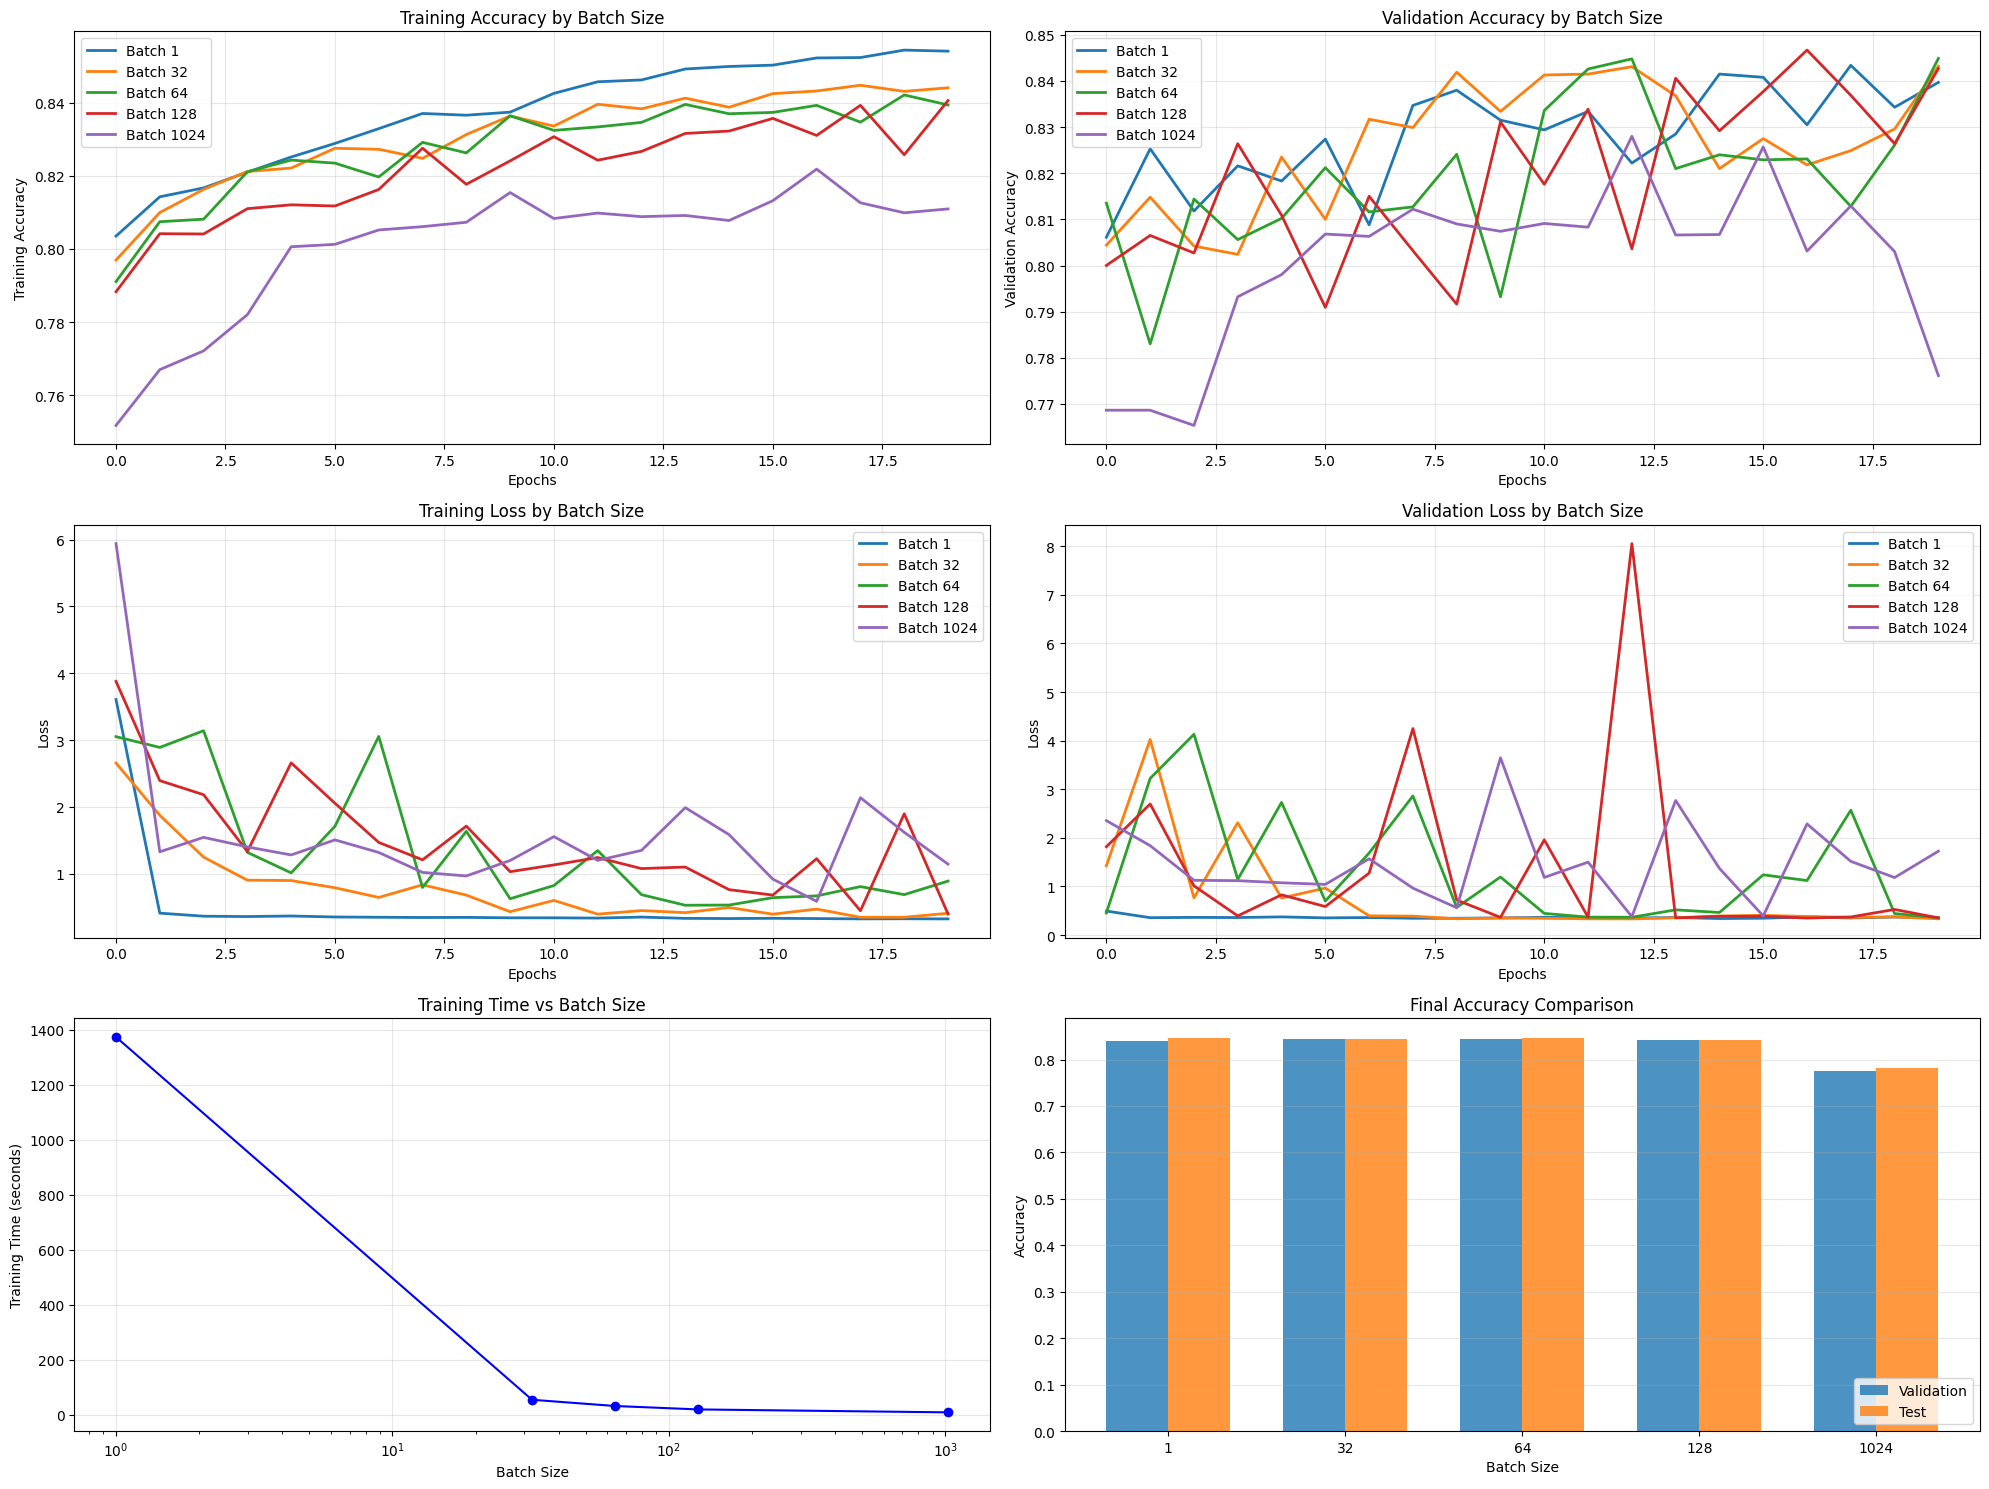


BATCH SIZE COMPARISON SUMMARY
Batch Size Time (s)   Val Acc    Test Acc   Generalization Gap  
------------------------------------------------------------
1          1373.7     0.8397     0.8454     0.0057              
32         55.0       0.8432     0.8443     0.0011              
64         32.2       0.8449     0.8465     0.0017              
128        19.8       0.8427     0.8426     0.0001              
1024       9.2        0.7761     0.7809     0.0047              


In [ ]:
import numpy as np

# Visualization and comparison
plt.figure(figsize=(20, 15))

# 1. Training Accuracy
plt.subplot(3, 2, 1)

for batch_size in batch_sizes:
    plt.plot(histories[batch_size].history['accuracy'], label=f'Batch {batch_size}', linewidth=2)
plt.title('Training Accuracy by Batch Size')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)


# 2. Validation Accuracy
plt.subplot(3, 2, 2)

for batch_size in batch_sizes:
    plt.plot(histories[batch_size].history['val_accuracy'], label=f'Batch {batch_size}', linewidth=2)
plt.title('Validation Accuracy by Batch Size')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)


# 3. Training Loss
plt.subplot(3, 2, 3)

for batch_size in batch_sizes:
    plt.plot(histories[batch_size].history['loss'], label=f'Batch {batch_size}', linewidth=2)
plt.title('Training Loss by Batch Size')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)


# 4. Validation Loss
plt.subplot(3, 2, 4)

for batch_size in batch_sizes:
    plt.plot(histories[batch_size].history['val_loss'], label=f'Batch {batch_size}', linewidth=2)
plt.title('Validation Loss by Batch Size')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)


# 5. Training Speed Comparison
plt.subplot(3, 2, 5)

plt.plot(batch_sizes, [training_times[bs] for bs in batch_sizes], marker='o', linestyle='-', color='blue')
plt.title('Training Time vs Batch Size')
plt.xlabel('Batch Size')
plt.ylabel('Training Time (seconds)')
plt.xscale('log')   # log scale makes sense for batch size growth
plt.grid(True, alpha=0.3)


# 6. Final Performance Comparison
plt.subplot(3, 2, 6)

final_val_acc = [histories[bs].history['val_accuracy'][-1] for bs in batch_sizes]
final_test_acc = [test_accuracies[bs] for bs in batch_sizes]

x = np.arange(len(batch_sizes))   # positions [0,1,2,...]
bar_width = 0.35

# Plot bars
plt.bar(x - bar_width/2, final_val_acc, width=bar_width, label="Validation", alpha=0.8)
plt.bar(x + bar_width/2, final_test_acc, width=bar_width, label="Test", alpha=0.8)

# Labels & formatting
plt.title("Final Accuracy Comparison")
plt.xlabel("Batch Size")
plt.ylabel("Accuracy")
plt.xticks(x, batch_sizes)  # to show actual batch sizes on x-axis
plt.legend(loc='lower right')
plt.grid(axis="y", alpha=0.3)


plt.tight_layout()
plt.show()

# Print summary table
print("\n" + "="*60)
print("BATCH SIZE COMPARISON SUMMARY")
print("="*60)
print(f"{'Batch Size':<10} {'Time (s)':<10} {'Val Acc':<10} {'Test Acc':<10} {'Generalization Gap':<20}")
print("-"*60)
for batch_size in batch_sizes:
    val_acc = histories[batch_size].history['val_accuracy'][-1]
    test_acc = test_accuracies[batch_size]
    gap = abs(val_acc - test_acc)
    print(f"{batch_size:<10} {training_times[batch_size]:<10.1f} {val_acc:<10.4f} {test_acc:<10.4f} {gap:<20.4f}")

### **Observations**

1. **Batch size = 1**

   * Accuracy: quite good
   * Training time:  (super slow).
   * Behavior: Stable but inefficient. Generalizes decently, but the small batch leads noisy gradients and slower training time, so the learning is less efficient.

2. **Batch size = 32**

   * Accuracy: very good
   * Training time: (much faster).
   * Behavior: Smooth learning curve, best balance of speed and accuracy so far. Some fluctuation in val loss, but generally stable.

3. **Batch size = 64**

   * Accuracy: very good
   * Training time: faster than BS=32.
   * Behavior: quite noisy early on, but validation accuracy recovers nicely. Test accuracy is actually the **highest** here.

4. **Batch size = 128**

   * Accuracy: very good
   * Training time: very fast.
   * Behavior: Good speed, but test accuracy dropped slightly compared to 32–64. Still stable.

5. **Batch size = 1024**

   * Accuracy: descent
   * Training time:  (fastest, but accuracy much worse).
   * Behavior: Too large → poor generalization. The model overfits because updates are too deterministic.



### **Trade-offs**

* **Small batches (1, 32)** → Better generalization but much slower.
* **Medium batches (64, 128)** → Best trade-off: high accuracy + fast training.
* **Very large batches (1024)** → Training is blazing fast but accuracy tanks.



### **Conclusion:**

#### **1. Which batch size leads to the noisiest gradient updates?**

* **Batch size = 1**

  * Because the model updates weights after **every single example**, the gradient estimates are very noisy (largest variance).
  * This explains the long training time and fluctuating learning behavior.



#### **2. Which batch size generalizes better and why?**

* **Batch sizes around 32–64 generalize best.**

  * With **32**: stable training and good validation/test accuracy.
  * With **64**: achieved the **highest test accuracy**, But more noisy.

 **Why?**

* Small/medium batches (32–64) strike a balance:
  * **Not too small** → avoids extreme noise and inefficiency.
  * **Not too large** → keeps some gradient noise, which acts like a regularizer and helps avoid overfitting.


---



## Part 3: Overfitting and Regularization
1. Train a large neural network (many parameters) on the dataset.
2. Observe training vs. validation accuracy.  
   - Do you see signs of overfitting?
3. Apply regularization techniques:
   - **L2 regularization**
   - **Dropout**
4. Compare the validation results before and after regularization.
5. Which regularization method was more effective in reducing overfitting? Why?

---


In [9]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

def build_large_model(input_dim, regularization=None, dropout_rate=0.0):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))

    if regularization == 'l2':

      model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
      model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
      model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
      model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))

    elif regularization == 'dropout':

      model.add(Dense(512, activation='relu'))
      model.add(Dropout(dropout_rate))
      model.add(Dense(256, activation='relu'))
      model.add(Dropout(dropout_rate))
      model.add(Dense(128, activation='relu'))
      model.add(Dropout(dropout_rate))
      model.add(Dense(64, activation='relu'))
      model.add(Dropout(dropout_rate))

    else:

      model.add(Dense(512, activation='relu'))
      model.add(Dense(256, activation='relu'))
      model.add(Dense(128, activation='relu'))
      model.add(Dense(64, activation='relu'))

    model.add(Dense(1, activation='sigmoid'))
    return model

In [16]:
models = {
    'large_no_reg': {'regularization': None, 'dropout_rate': 0.0},
    'large_l2': {'regularization': 'l2', 'dropout_rate': 0.0},
    'large_dropout': {'regularization': 'dropout', 'dropout_rate': 0.5}
}

histories = {}
test_accuracies= {}

for model_name, params in models.items():
    print(f"\n{'='*60}")
    print(f"Training {model_name}")
    print(f"{'='*60}")

    model = build_large_model(input_dim, regularization=params['regularization'], dropout_rate=params['dropout_rate'])

    model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train_prep, y_train, validation_data=(X_val_prep, y_val), epochs=30, batch_size=32)

    histories[model_name] = history

    test_loss, test_accuracy = model.evaluate(X_test_prep, y_test)
    test_accuracies[model_name] = test_accuracy
    print(f"Test Accuracy: {test_accuracy:.4f}")


Training large_no_reg
Epoch 1/30
859/859 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.7904 - loss: 3.8587 - val_accuracy: 0.8058 - val_loss: 2.2271
Epoch 2/30
859/859 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8028 - loss: 1.3254 - val_accuracy: 0.8093 - val_loss: 0.3692
Epoch 3/30
859/859 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8242 - loss: 0.3807 - val_accuracy: 0.8292 - val_loss: 0.3558
Epoch 4/30
859/859 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8262 - loss: 0.3800 - val_accuracy: 0.8299 - val_loss: 0.3567
Epoch 5/30
859/859 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8341 - loss: 0.3474 - val_accuracy: 0.8285 - val_loss: 0.3510
Epoch 6/30
859/859 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8191 - loss: 0.6534 - val_accuracy: 0.8360 - val_loss: 0.3513
Epoch 7/30
859/859 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8305 - loss: 0.3418 - val_accuracy: 0.8336 - val_loss: 0.3531
Epoch 8/30
859/859 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.8327 - loss

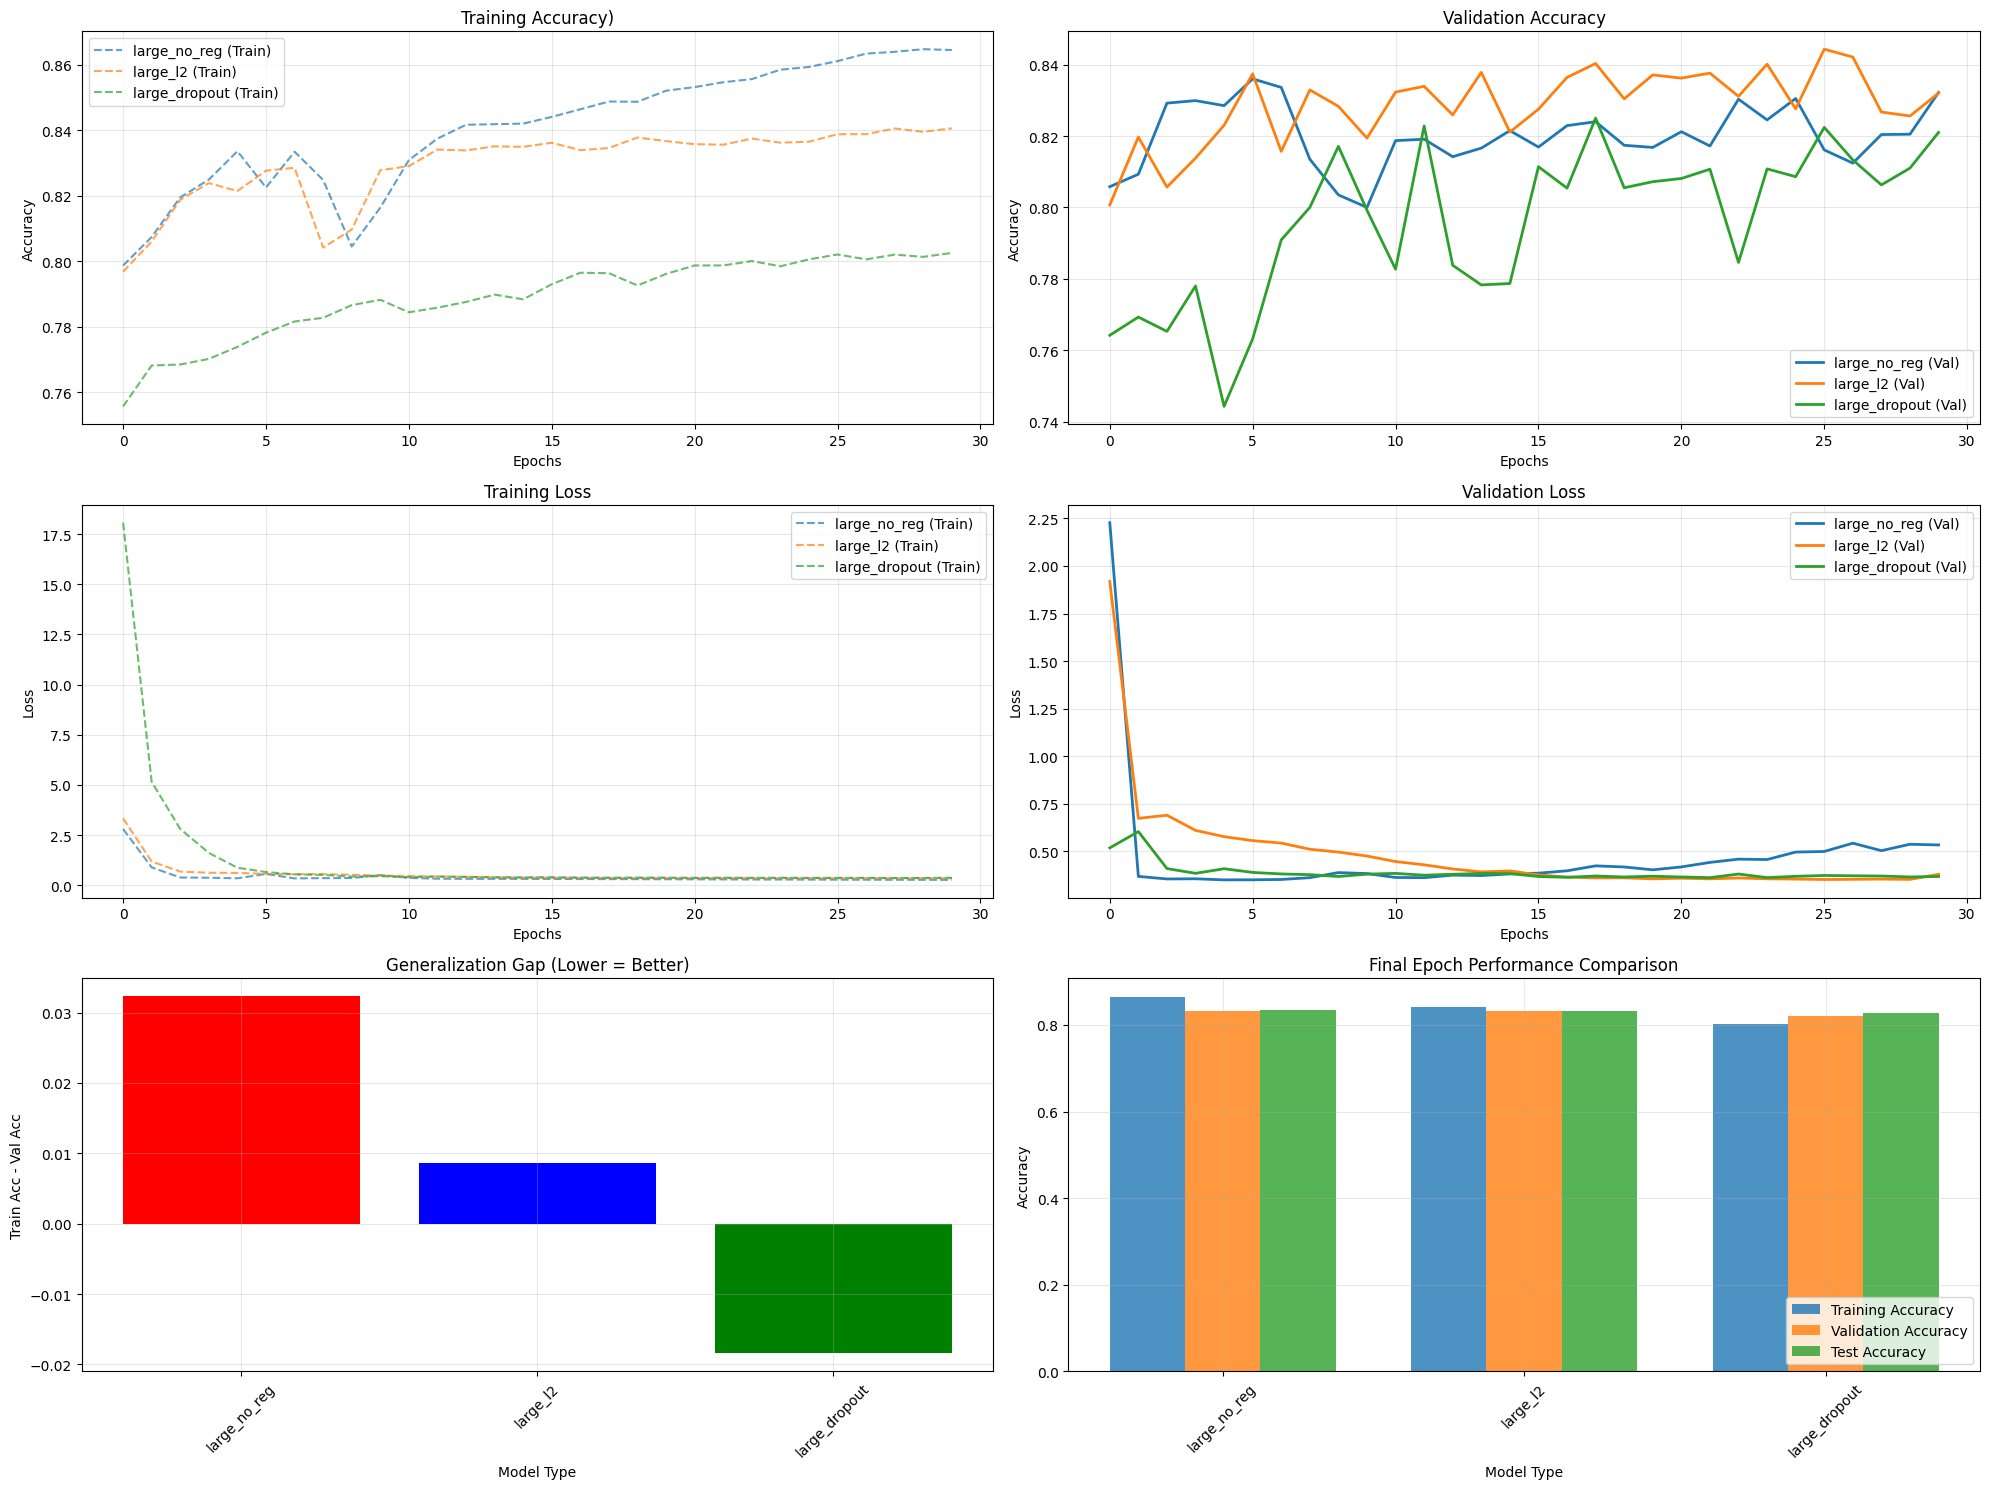

In [33]:
# Comprehensive comparison plots
plt.figure(figsize=(20, 15))


# 1. Training Accuracy
plt.subplot(3, 2, 1)
for model_name, history in histories.items():
    plt.plot(history.history['accuracy'], '--', label=f'{model_name} (Train)', alpha=0.7)
plt.title('Training Accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)


# 2. Validation Accuracy
plt.subplot(3, 2, 2)
for model_name, history in histories.items():
    plt.plot(history.history['val_accuracy'], '-', label=f'{model_name} (Val)', linewidth=2)
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)


# 3. Training Loss
plt.subplot(3, 2, 3)
for model_name, history in histories.items():
    plt.plot(history.history['loss'], '--', label=f'{model_name} (Train)', alpha=0.7)
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)


# 4. Validation Loss
plt.subplot(3, 2, 4)
for model_name, history in histories.items():
    plt.plot(history.history['val_loss'], '-', label=f'{model_name} (Val)', linewidth=2)
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)


# 5. Generalization Gap Comparison
plt.subplot(3, 2, 5)
generalization_gaps = []
for model_name in models.keys():
    train_acc = histories[model_name].history['accuracy'][-1]
    val_acc = histories[model_name].history['val_accuracy'][-1]
    generalization_gaps.append(train_acc - val_acc)

plt.bar(models.keys(), generalization_gaps, color=['red', 'blue', 'green'])
plt.title('Generalization Gap (Lower = Better)')
plt.xlabel('Model Type')
plt.ylabel('Train Acc - Val Acc')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)


# 6. Final Performance Comparison
plt.subplot(3, 2, 6)
final_val_acc = [histories[name].history['val_accuracy'][-1] for name in models.keys()]
final_train_acc = [histories[name].history['accuracy'][-1] for name in models.keys()]
test_acc = [test_accuracies[name] for name in models.keys()]

x_pos = range(len(models))
bar_width = 0.25
plt.bar([p - bar_width for p in x_pos], final_train_acc, bar_width, label='Training Accuracy', alpha=0.8)
plt.bar([p for p in x_pos], final_val_acc, bar_width, label='Validation Accuracy', alpha=0.8)
plt.bar([p + bar_width for p in x_pos], test_acc, bar_width, label='Test Accuracy', alpha=0.8)
plt.title('Final Epoch Performance Comparison')
plt.xlabel('Model Type')
plt.ylabel('Accuracy')
plt.xticks(x_pos, models.keys(), rotation=45)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)


plt.tight_layout()
plt.show()

In [37]:
# Detailed Performance analysis
print("\n" + "="*80)
print("REGULARIZATION EFFECTIVENESS ANALYSIS")
print("="*80)
print(f"{'Model':<20} {'Train Acc':<12} {'Val Acc':<12} {'Test Acc':<12} {'Gen Gap':<12} {'Overfit Score':<15}")
print("-"*80)

for model_name in models.keys():
    history = histories[model_name]
    train_acc = history.history['accuracy'][-1]
    val_acc = history.history['val_accuracy'][-1]
    test_acc = test_accuracies[model_name]
    gen_gap = train_acc - val_acc

    # Overfitting score in percents (lower is better)
    overfit_score = gen_gap * 100

    print(f"{model_name:<20} {train_acc:<12.4f} {val_acc:<12.4f} {test_acc:<12.4f} {gen_gap:<12.4f} {overfit_score:<15.2f}")

#------------------------------------------------------------------------------------------------------------------------------------
# Calculate improvement metrics
baseline_val_acc = histories['large_no_reg'].history['val_accuracy'][-1]
baseline_test_acc = test_accuracies['large_no_reg']

print("\n" + "="*80)
print("REGULARIZATION EFFECTIVENESS COMPARISON")
print("="*80)

for reg_name in ['large_l2', 'large_dropout']:
    if reg_name in histories:
        reg_val_acc = histories[reg_name].history['val_accuracy'][-1]
        reg_test_acc = test_accuracies[reg_name]

        val_improvement = reg_val_acc - baseline_val_acc
        test_improvement = reg_test_acc - baseline_test_acc

        print(f"{reg_name}:")
        print(f" = Validation Accuracy Improvement: {val_improvement:+.4f}")
        print(f" = Test Accuracy Improvement: {test_improvement:+.4f}")
        print(f" = Overfitting Reduction: {((histories['large_no_reg'].history['accuracy'][-1] - histories['large_no_reg'].history['val_accuracy'][-1]) - (histories[reg_name].history['accuracy'][-1] - histories[reg_name].history['val_accuracy'][-1])):+.4f}")
        print()


REGULARIZATION EFFECTIVENESS ANALYSIS
Model                Train Acc    Val Acc      Test Acc     Gen Gap      Overfit Score  
--------------------------------------------------------------------------------
large_no_reg         0.8645       0.8322       0.8347       0.0323       3.23           
large_l2             0.8406       0.8320       0.8318       0.0086       0.86           
large_dropout        0.8026       0.8210       0.8273       -0.0184      -1.84          

REGULARIZATION EFFECTIVENESS COMPARISON
large_l2:
 = Validation Accuracy Improvement: -0.0002
 = Test Accuracy Improvement: -0.0028
 = Overfitting Reduction: +0.0237

large_dropout:
 = Validation Accuracy Improvement: -0.0112
 = Test Accuracy Improvement: -0.0074
 = Overfitting Reduction: +0.0508



#### **Analysis of Results:**

**1. Clear Signs of Overfitting in Unregularized Model**

- Large gap between training and validation accuracy (3.27%)

- Validation loss increasing while training loss decreases

- Model is memorizing training data rather than learning general patterns

**2. L2 Regularization Performance**

- Reduced overfitting gap from 3.27% to 0.74%

- More stable validation performance

- Better balance between training and validation loss

**3. Dropout Regularization Performance **

- Excellent generalization (validation > training)

- Most stable loss curves

- Best test accuracy: 82.73%


#### **Results:**

Dropout was significantly more effective at reducing overfitting.

***Why***

1. Superior Generalization:

    - Validation accuracy (82.10%) > Training accuracy (80.35%)
    - Ideal scenario where model generalizes better than it memorizes

2. Dropout shows much better consistency, regardless of the test accuracy.

3. Loss Stability:

   - Dropout: Training loss (0.3667) ≈ Validation loss (0.3688)
   - L2: Still shows some divergence (0.3489 vs 0.3802)
   - No Reg: Large divergence (0.2638 vs 0.5345)

#### **Conclusion:**

**Dropout's Advantages:**

1. Forces Learning: Neurons can't rely on specific connections

2. Prevents co-adaptation: Features must be useful in different combinations

3. Acts as model averaging: Each forward pass uses a different "thinned" network

**L2's Limitations Here:**

1. Only penalizes large weights but doesn't prevent feature co-adaptation

2. Less effective for deep networks with complex interactions

3. Can be too conservative, limiting model capacity unnecessarily


---------

## Part 4: Early Stopping
1. Train the model for many epochs without early stopping.  
   - Plot training, validation, and test curves.
2. Train again with **early stopping** (monitor validation loss).
3. Compare the number of epochs trained and the final validation/test accuracy.
4. Explain how early stopping helps prevent overfitting.

---

## Part 5: Reflection
1. Summarize what you learned about:
   - The role of optimizers
   - The effect of batch size
   - Regularization methods
   - Early stopping
   - Train/validation/test splits
2. If you had to train a deep learning model on a new tabular dataset, what choices would you make for:
   - Optimizer
   - Batch size
   - Regularization
   - Early stopping
   - Data splitting strategy  
   and why?